# 4.2 T-cells annotation in Tumor

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-20"

## Introduction

Integrate CD3+ cells from CD45+ and CD3+ enrich compartment from T0 (Tumor)

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(harmony)
library(dittoSeq)
library(EnhancedVolcano)
library(scater) 
library(scran)
}))

In [3]:
set.seed(0)
source(here("utils/bin.R"))
source(here("utils/style.R"))

source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))

## Load data

In [4]:
cd45_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.0-l1_T0_CD45pos.rds")))
cd3_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.0-l1_T0_CD3pos.rds")))

In [5]:
levels(cd3_obj)

[1] "CD8 T-cells"           "Tregs"                 "Naive T-cells"        
[4] "CD8 Memory"            "Proliferative T-cells"

In [6]:
levels(cd45_obj)

[1] "NK"              "Monocytes"       "CD8 T-cells"     "Tregs"          
[5] "B-cells"         "Macrophages"     "Plasma cells"    "Mast cells"     
[9] "Dendritic cells"

In [7]:
cd45_obj <- subset(cd45_obj, idents=c('CD8 T-cells','Tregs'))

In [8]:
print(table(rowSums(as.matrix(cd45_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(cd45_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
cd45_obj[['RNA']]@counts <- cd45_obj[['RNA']]@counts[rownames(keep_genes), ]
cd45_obj[['RNA']]@data <- cd45_obj[['RNA']]@data[rownames(keep_genes), ]


FALSE  TRUE 
22462  5321 


In [9]:
list_objects = list()
list_objects$T0_CD3pos <- cd3_obj
list_objects$T0_CD45pos <- cd45_obj

In [10]:
fractions <- names(list_objects)

In [11]:
list_objects <- lapply(names(list_objects), function(frc) {
    obj <- list_objects[[frc]]
    obj@meta.data$sample_id <- frc
    
    df_meta <- obj@meta.data
    seurat.matrix <- obj@assays[["RNA"]]@counts 

    colnames(seurat.matrix) <- paste(frc,colnames(seurat.matrix), sep='_')
    rownames(df_meta) <- paste(frc,rownames(df_meta), sep='_')

    obj_new <- CreateSeuratObject(seurat.matrix, meta.data=df_meta)
    obj_new
})
list_objects <- setNames(list_objects, fractions)

In [12]:
seurat_obj <- merge(
  x = list_objects[[1]],
  y = list_objects[[2]])

### Get variable features from fractions

In [13]:
find_hvgs <- function(sam, list_objects) {
    
    list_objects[[sam]] <- list_objects[[sam]]  %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4)
    
    sce <- as.SingleCellExperiment(list_objects[[sam]])
    gene_var <- modelGeneVar(sce)
    
    tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)
    
    plt <- gene_var %>% 
        as.data.frame() %>% 
        ggplot(aes(mean, total)) +
        geom_point() +
        geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
        labs(x = "Mean of log-expression", y = "Variance of log-expression") + 
        ggtitle(sam) +
        geom_text(data=tops, aes(mean,total,label=rownames(tops)))
    
    hvg <- getTopHVGs(gene_var,fdr.threshold = 0.05)
    list(plots=plt, hvgs=hvg)  
}

plts <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$plots)
hvgs <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$hvgs)

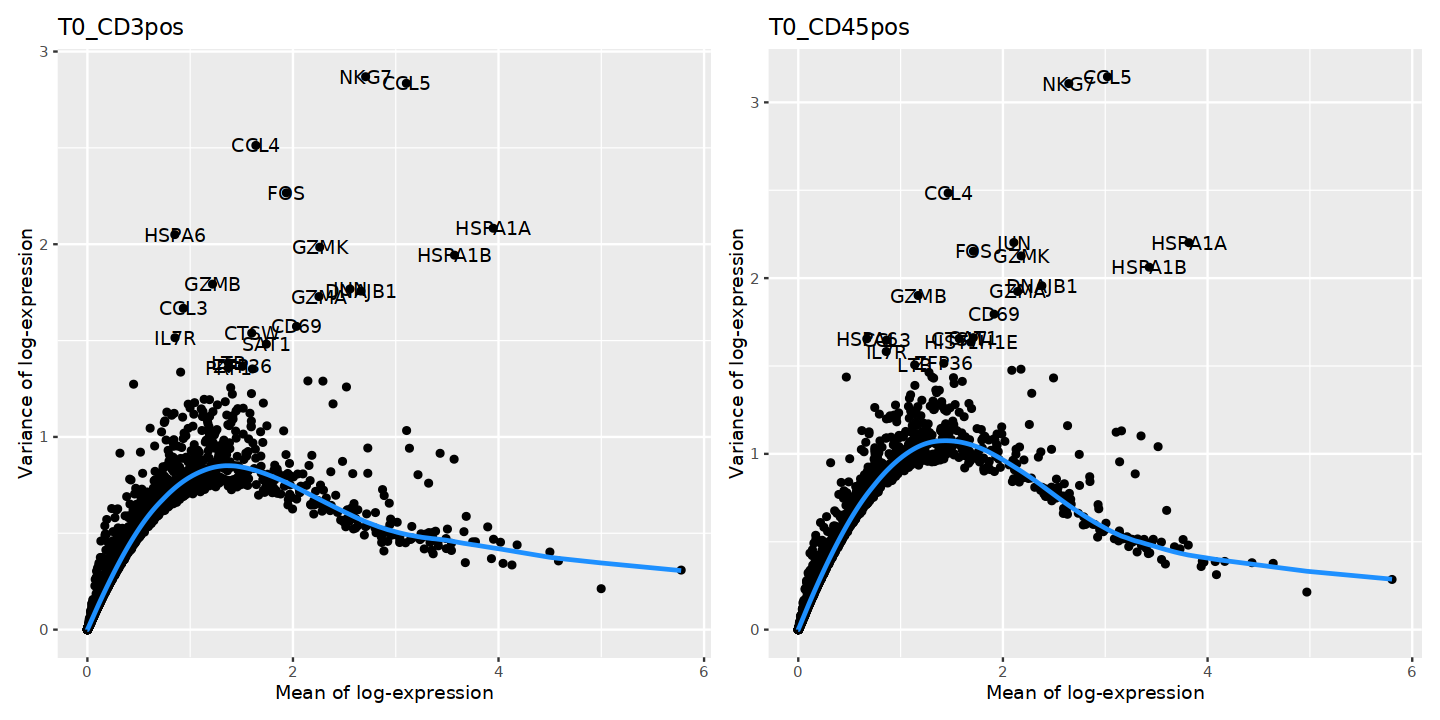

In [14]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
plts[[1]]+plts[[2]]

In [15]:
hvg_common <- union(hvgs[[1]], hvgs[[2]])
length(hvg_common)

[1] 2540

Remove TCR Genes from the HVG as they affect the clustering of similar T-cell phenotypes (https://academic.oup.com/bfg/article/22/3/263/6874511)

In [16]:
hvg_common <- hvg_common[!grepl("^TR[AB][VJC]", hvg_common)]
length(hvg_common)

[1] 2432

In [17]:
VariableFeatures(seurat_obj) <- hvg_common

## Normalization and Embedding

In [18]:
seurat_obj <- NormalizeData(
seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvg_common) %>% 
  RunPCA(features=hvg_common)

Centering and scaling data matrix

PC_ 1 
Positive:  NKG7, CCL5, GZMK, CTSW, PRF1, CCL4, CST7, LYST, VCAM1, CCL4L2 
	   GZMA, KLRK1, GZMB, FCGR3A, GZMH, CCL3, KLRC4, AOAH, LINC01934, CBLB 
	   AL133405.2, RGS2, IFNG, ID2, TNFRSF9, CD74, CRTAM, TNFSF4, HLA-DRB1, CCL3L1 
Negative:  FOXP3, IL12RB2, SELL, IL7R, IL2RA, TIMP1, BATF, KLRB1, CCR8, LTB 
	   RTKN2, IL32, ICOS, S100A4, IL1R2, TMSB10, AL136456.1, LEF1, TSC22D3, LINC02195 
	   BCAS1, CTLA4, SAT1, AL450352.1, ZFP36L1, SLC2A3, LINC02099, BACH2, DEPP1, TCF7 
PC_ 2 
Positive:  TCF7, TXNIP, LEF1, HSPA1A, HSPA1B, IL7R, ZNF683, DNAJB1, PLAC8, BACH2 
	   KLRC2, KLRD1, AOAH, LINC02446, XCL1, AREG, TAFA1, TSPYL2, CCR7, NR4A1 
	   JUN, KLRK1, XCL2, BTG2, PELI2, PLK2, TSC22D1, TSC22D3, AFF3, HSPA6 
Negative:  MKI67, RRM2, STMN1, TOP2A, HIST1H3C, HIST1H3B, CENPF, ASPM, HIST1H1B, TUBB 
	   TUBA1B, HIST1H2AH, HMGB2, HIST1H2AL, HIST1H4C, HIST1H3F, GAPDH, HIST1H1C, HIST1H1E, ACTB 
	   MT2A, HIST1H1D, ACTG1, GZMA, LGALS1, CTLA4, CD74, TMSB10, HLA-DR

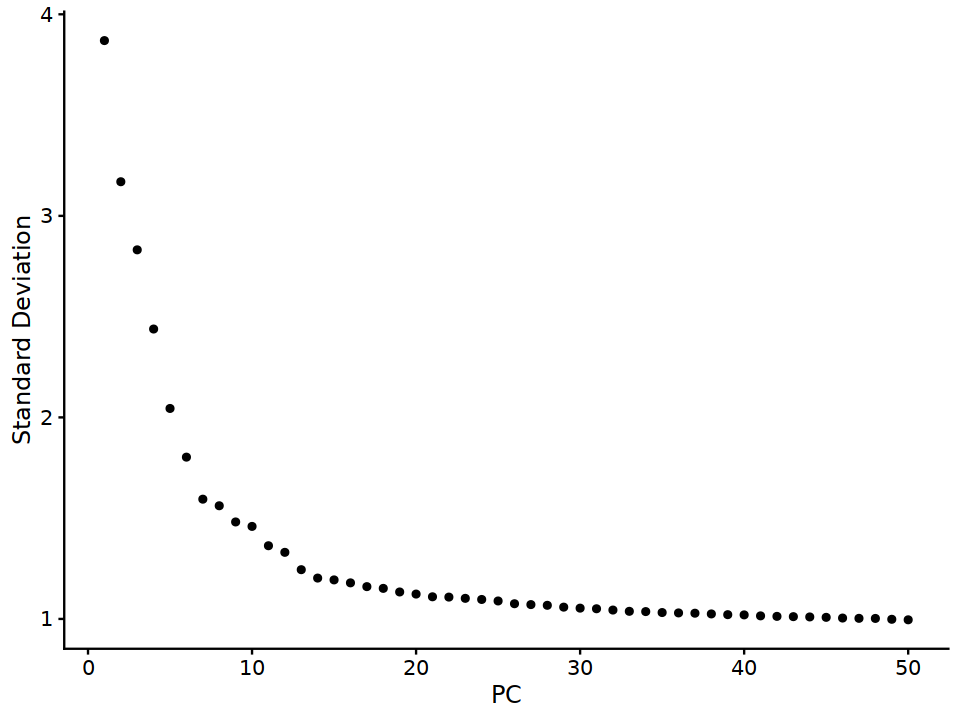

In [19]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
ElbowPlot(seurat_obj, n=50)

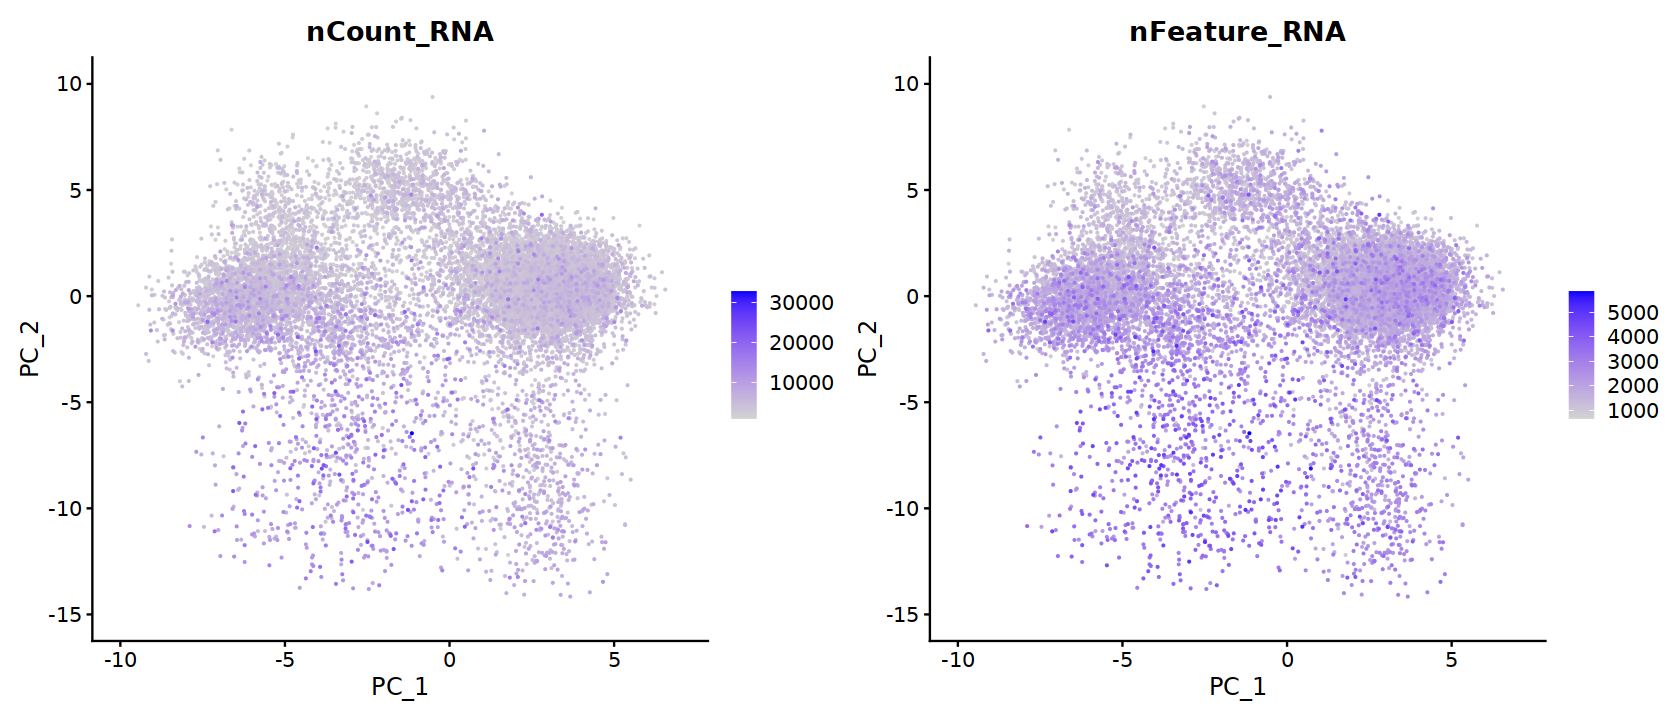

In [20]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
    features = c("nCount_RNA", "nFeature_RNA"), order = T)

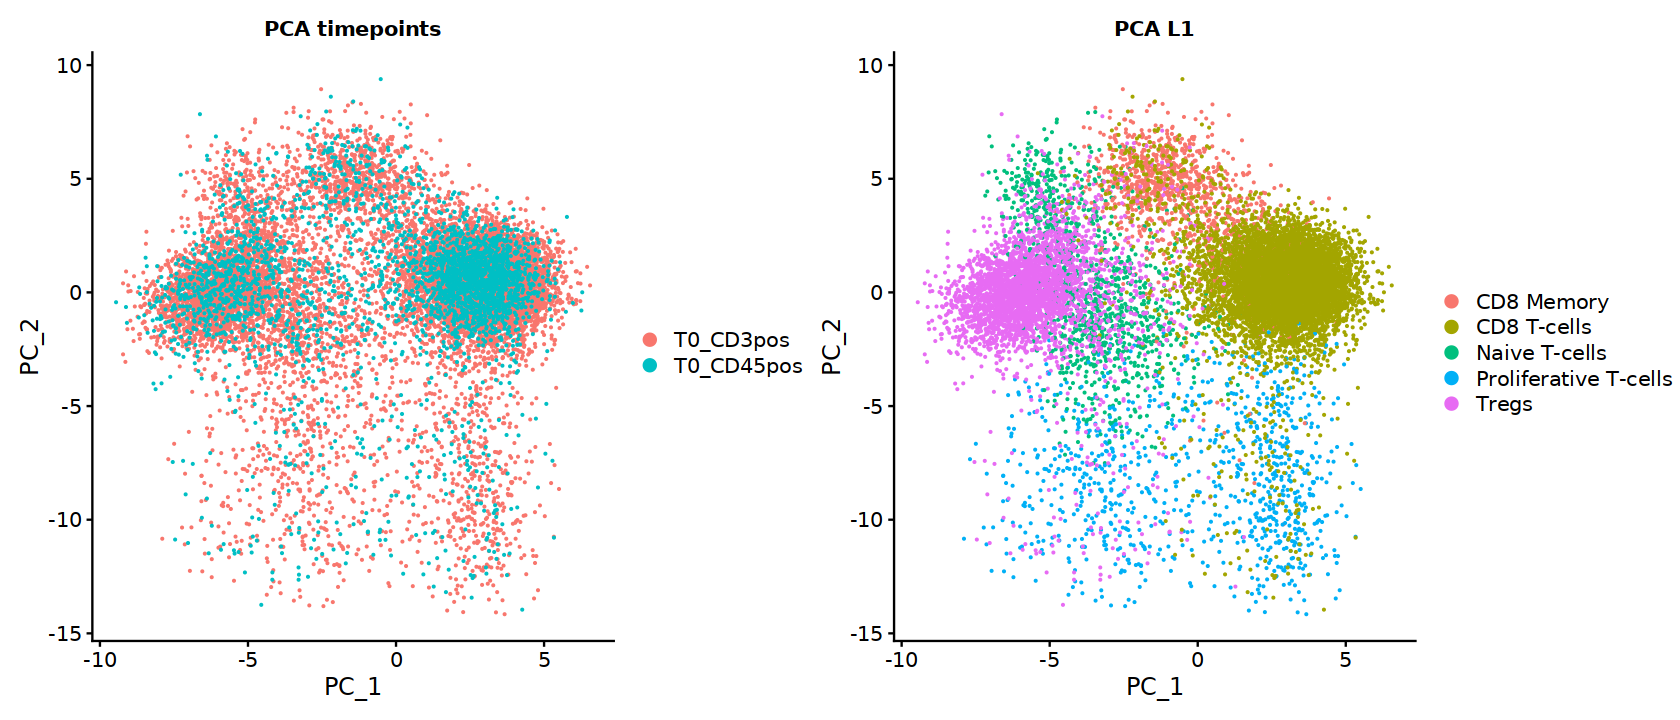

In [21]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dp1 <- DimPlot(
  seurat_obj,
  reduction = "pca",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('PCA timepoints') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp2 <- DimPlot(
  seurat_obj,
  reduction = "pca",
  group.by = "l1_annot",
  pt.size = 0.1
) + ggtitle('PCA L1') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp1 + dp2

In [22]:
comp = 15

In [23]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:19:42 UMAP embedding parameters a = 0.9922 b = 1.112

17:19:42 Read 14789 rows and found 15 numeric columns

17:19:42 Using Annoy for neighbor search, n_neighbors = 30

17:19:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:19:43 Writing NN index file to temp file /scratch_tmp/34289041/Rtmpg5vIX3/file3d16456b3b912

17:19:43 Searching Annoy index using 1 thread, search_k = 3000

17:19:48 Annoy recall = 100%

17:19:49 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:19:51 Initializing from normalized Laplacian + noise (using irlba)

17:19:51 Commencing optimization for 200 epochs, with 619864 positive edges

17:20:07 Optimization finished



In [24]:
p1 <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration of fractions)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

p2 <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "l1_annot",
  pt.size = 0.1
) + ggtitle('UMAP (sample-specific L1 annot)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

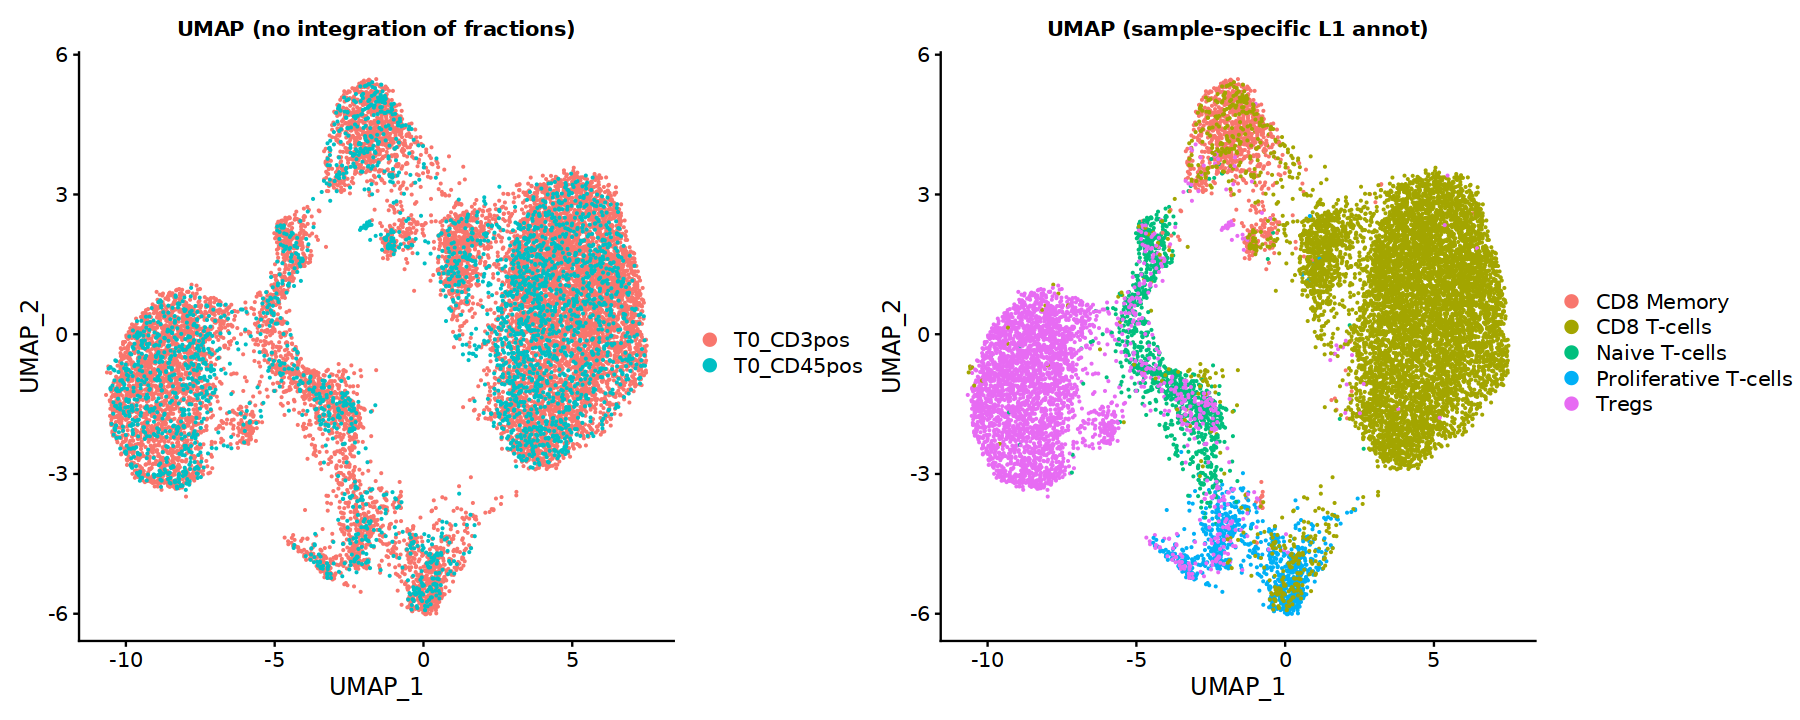

In [25]:
options(repr.plot.width = 15, repr.plot.height = 6, warn=-1,verbose = FALSE)
p1+p2

In [26]:
tcell_markers = c("CD3E","CD3D", "CD4", "CD8A","CD8B","ANXA1",
                  "NKG7", "GZMH","GZMB","IFNG","CCL5","PRF1",
                  "ICOS","FOXP3", 
                  "GATA3","RORA","SELL", "LEF1", "TCF7",
                  "NCAM1", "FCGR3A",
                  "TRDC", "TRGC1","TRGC2","ZNF683", 
                  "CX3CR1", "ITGAE","CD40LG", "CXCL13",
                  "PDCD1", "HAVCR2", "LAG3", "TOX", "ENTPD1", "IL7R")

### Integration with Harmony

In [27]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [28]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



In [29]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

17:20:17 UMAP embedding parameters a = 0.9922 b = 1.112

17:20:17 Read 14789 rows and found 15 numeric columns

17:20:17 Using Annoy for neighbor search, n_neighbors = 30

17:20:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:20:19 Writing NN index file to temp file /scratch_tmp/34289041/Rtmpg5vIX3/file3d164321b0b4f

17:20:19 Searching Annoy index using 1 thread, search_k = 3000

17:20:24 Annoy recall = 100%

17:20:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:20:26 Initializing from normalized Laplacian + noise (using irlba)

17:20:26 Commencing optimization for 200 epochs, with 617406 positive edges

17:20:43 Optimization finished



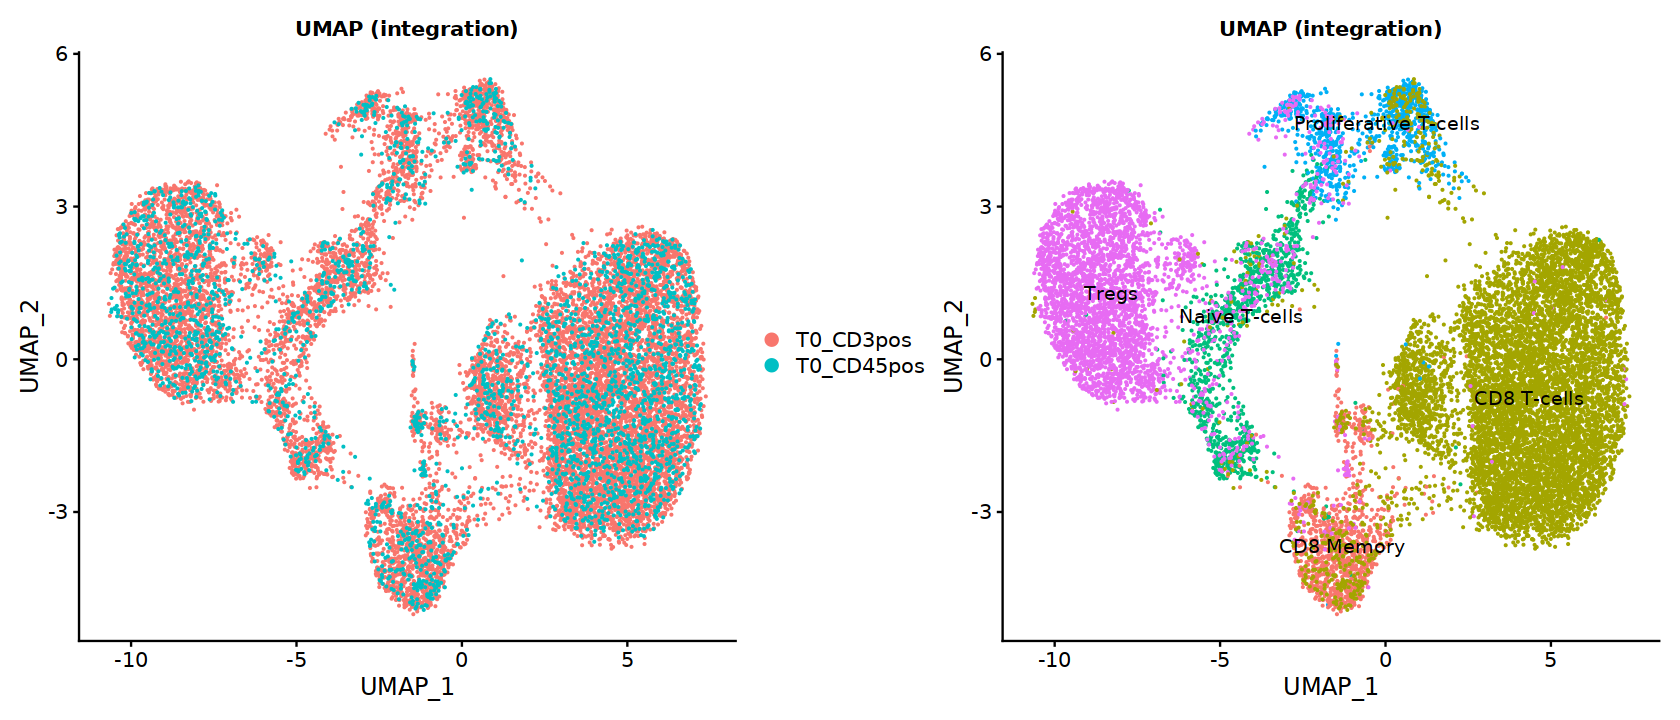

In [30]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dpt <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dpl2 <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "l1_annot",
  pt.size = 0.1,
  label=T
) + NoLegend() + ggtitle('UMAP (integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

dpt + dpl2

Integration seems almost not necessary

## Clustering

In [31]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", 
                            dims = 1:comp)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.05
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14789
Number of edges: 459427

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9545
Number of communities: 4
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14789
Number of edges: 459427

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9398
Number of communities: 6
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14789
Number of edges: 459427

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9275
Number of communities: 6
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14789
Number of edges: 459427

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9150
Number of communities: 6
Elapsed time: 2 seconds
Modularity Optim

In [32]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

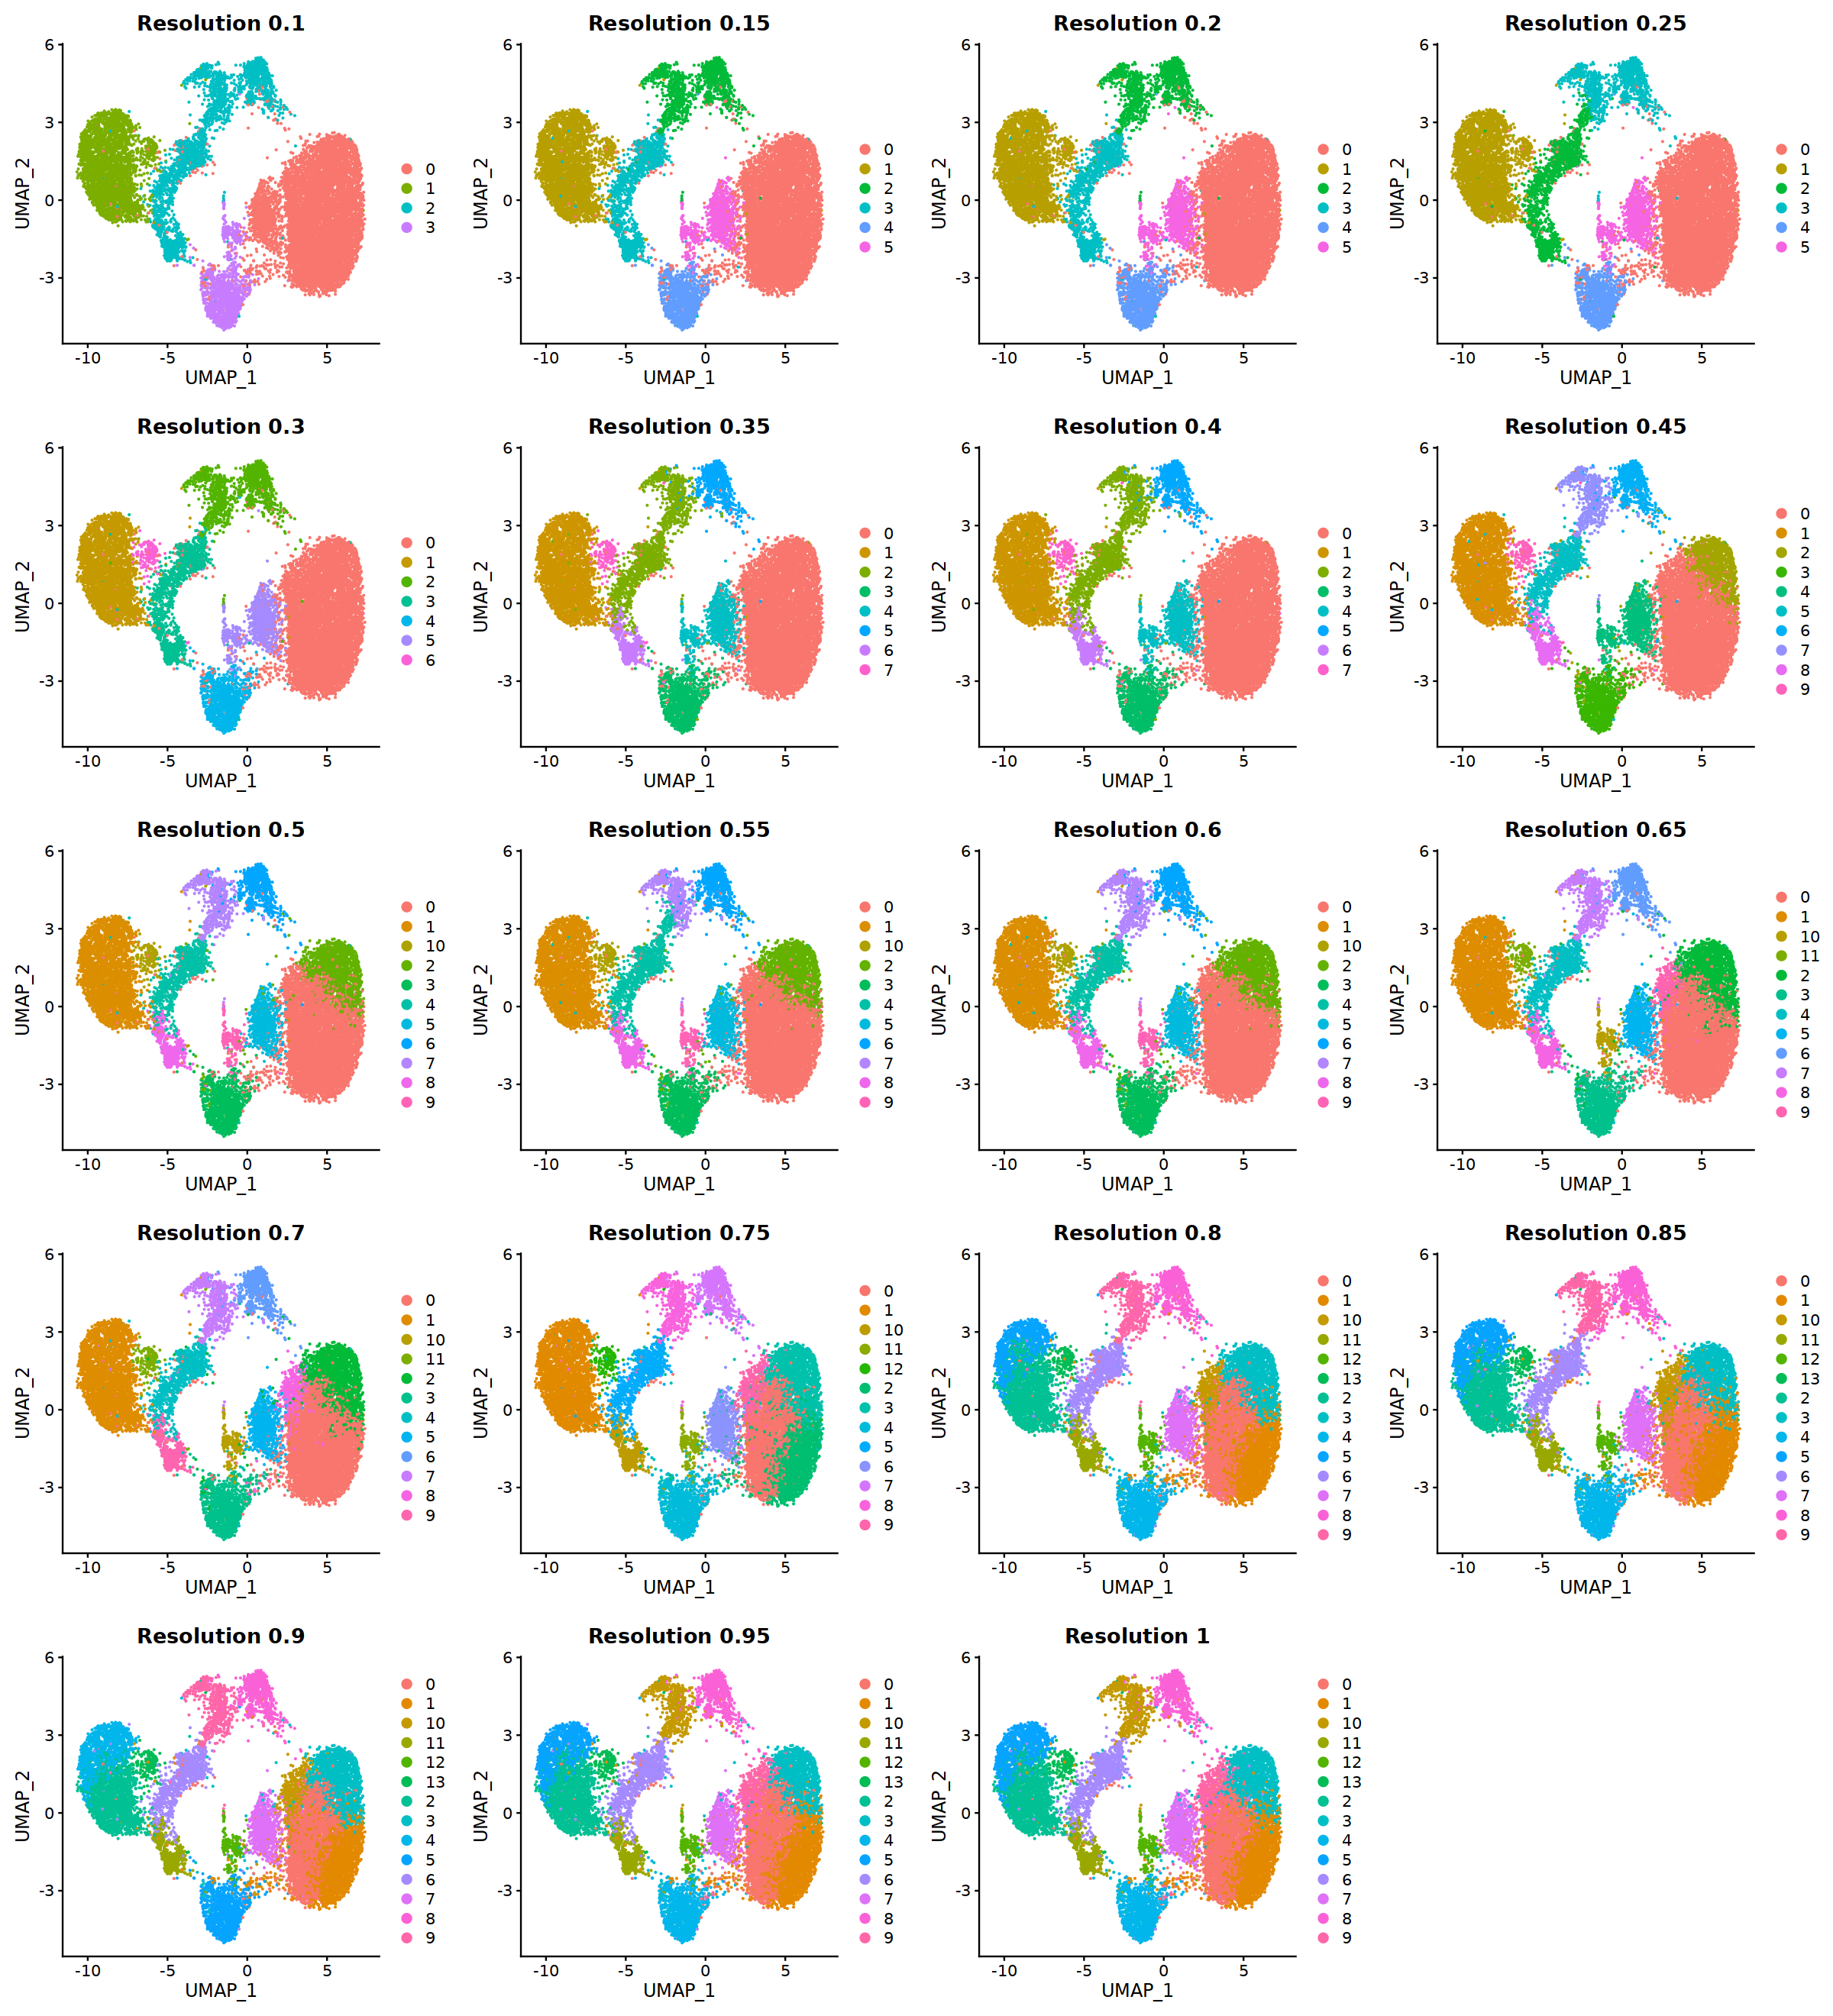

In [33]:
options(repr.plot.width = 20, repr.plot.height = 22, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=5)
cp

### Resolution chosen

In [34]:
reso=0.8

In [35]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14789
Number of edges: 459427

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8183
Number of communities: 14
Elapsed time: 2 seconds


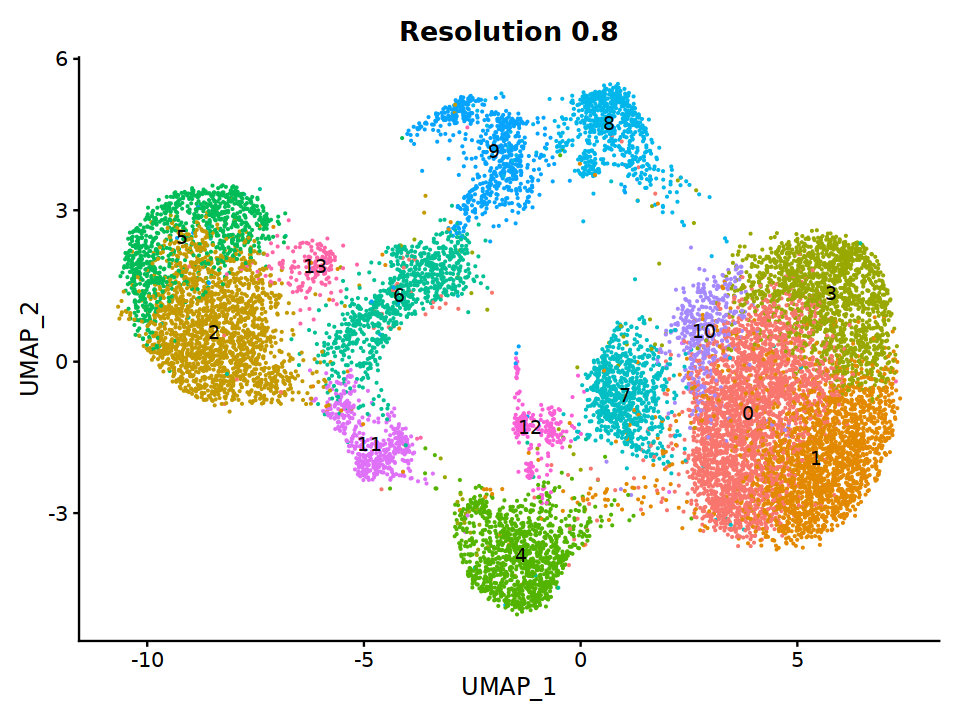

In [36]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

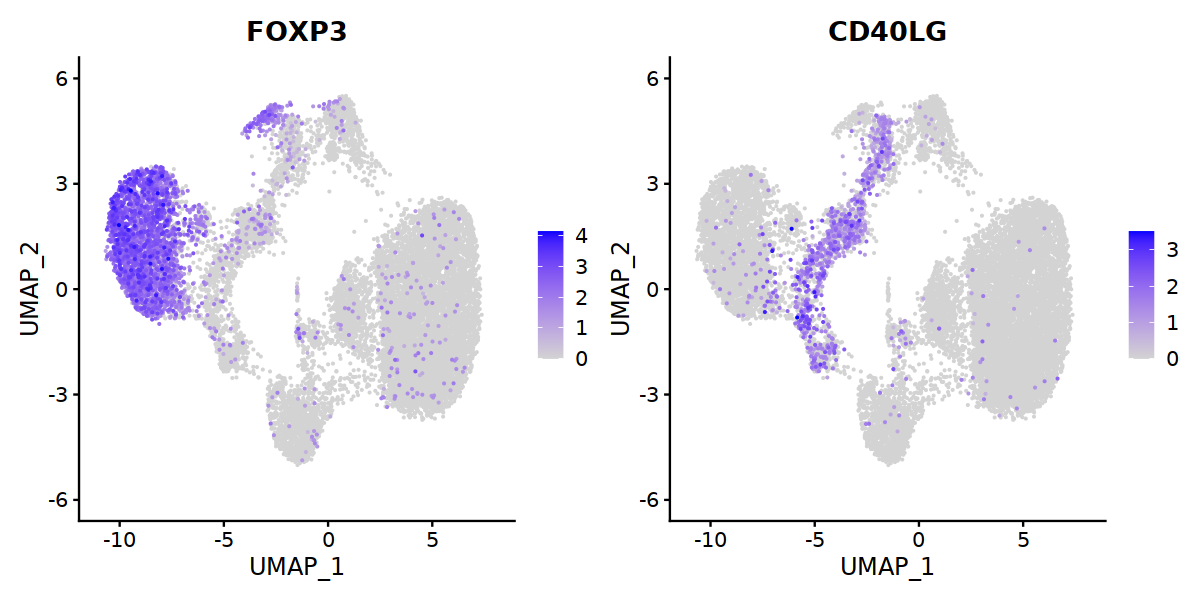

In [37]:
options(repr.plot.width = 10, repr.plot.height = 5, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("FOXP3", "CD40LG"), ncol=2,
            order = TRUE)

In [38]:
seurat_obj <- FindSubCluster(
  seurat_obj,
  cluster="9",
  graph.name = "RNA_snn",
  subcluster.name = "subclustering",
  resolution = 0.1,
  algorithm = 1
)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 631
Number of edges: 19051

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9016
Number of communities: 2
Elapsed time: 0 seconds


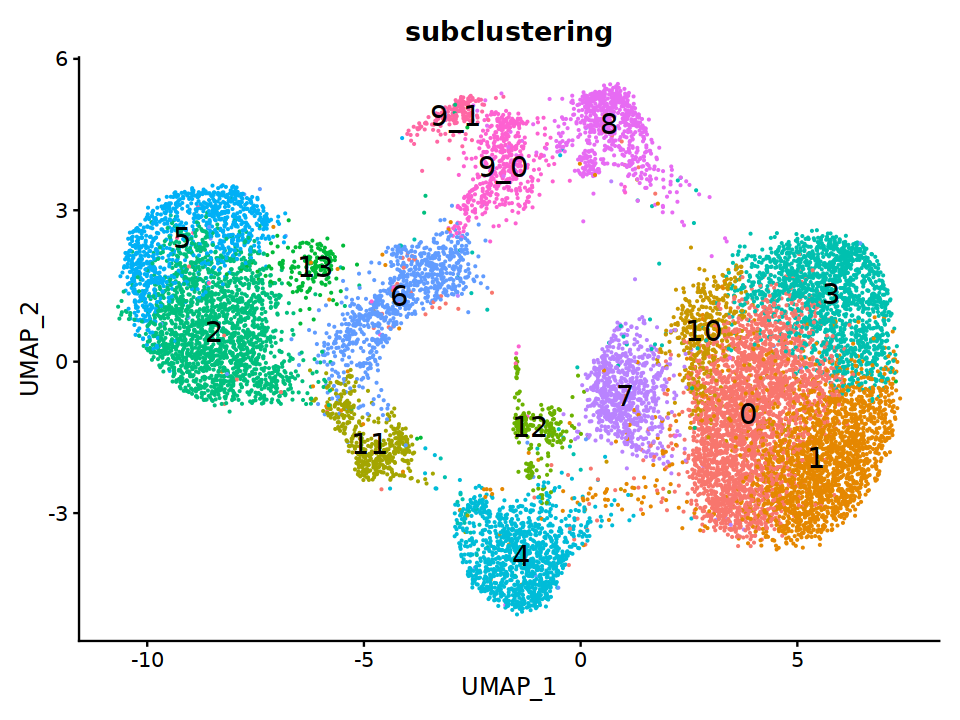

In [39]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", group.by = "subclustering", label = TRUE, label.size = 6) + NoLegend()

In [40]:
seurat_obj <- SetIdent(seurat_obj, value=seurat_obj@meta.data[["subclustering"]])
seurat_obj$Tcell_clusters <- Idents(seurat_obj)

In [41]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct=0.1, logfc.threshold=0.1, 
                              random.seed=0, max.cells.per.ident=2000, 
                              only.pos=TRUE)

Calculating cluster 4

Calculating cluster 10

Calculating cluster 0

Calculating cluster 3

Calculating cluster 1

Calculating cluster 7

Calculating cluster 9_1

Calculating cluster 6

Calculating cluster 2

Calculating cluster 9_0

Calculating cluster 5

Calculating cluster 11

Calculating cluster 8

Calculating cluster 13

Calculating cluster 12



In [42]:
rna.markers <- rna.markers %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC))

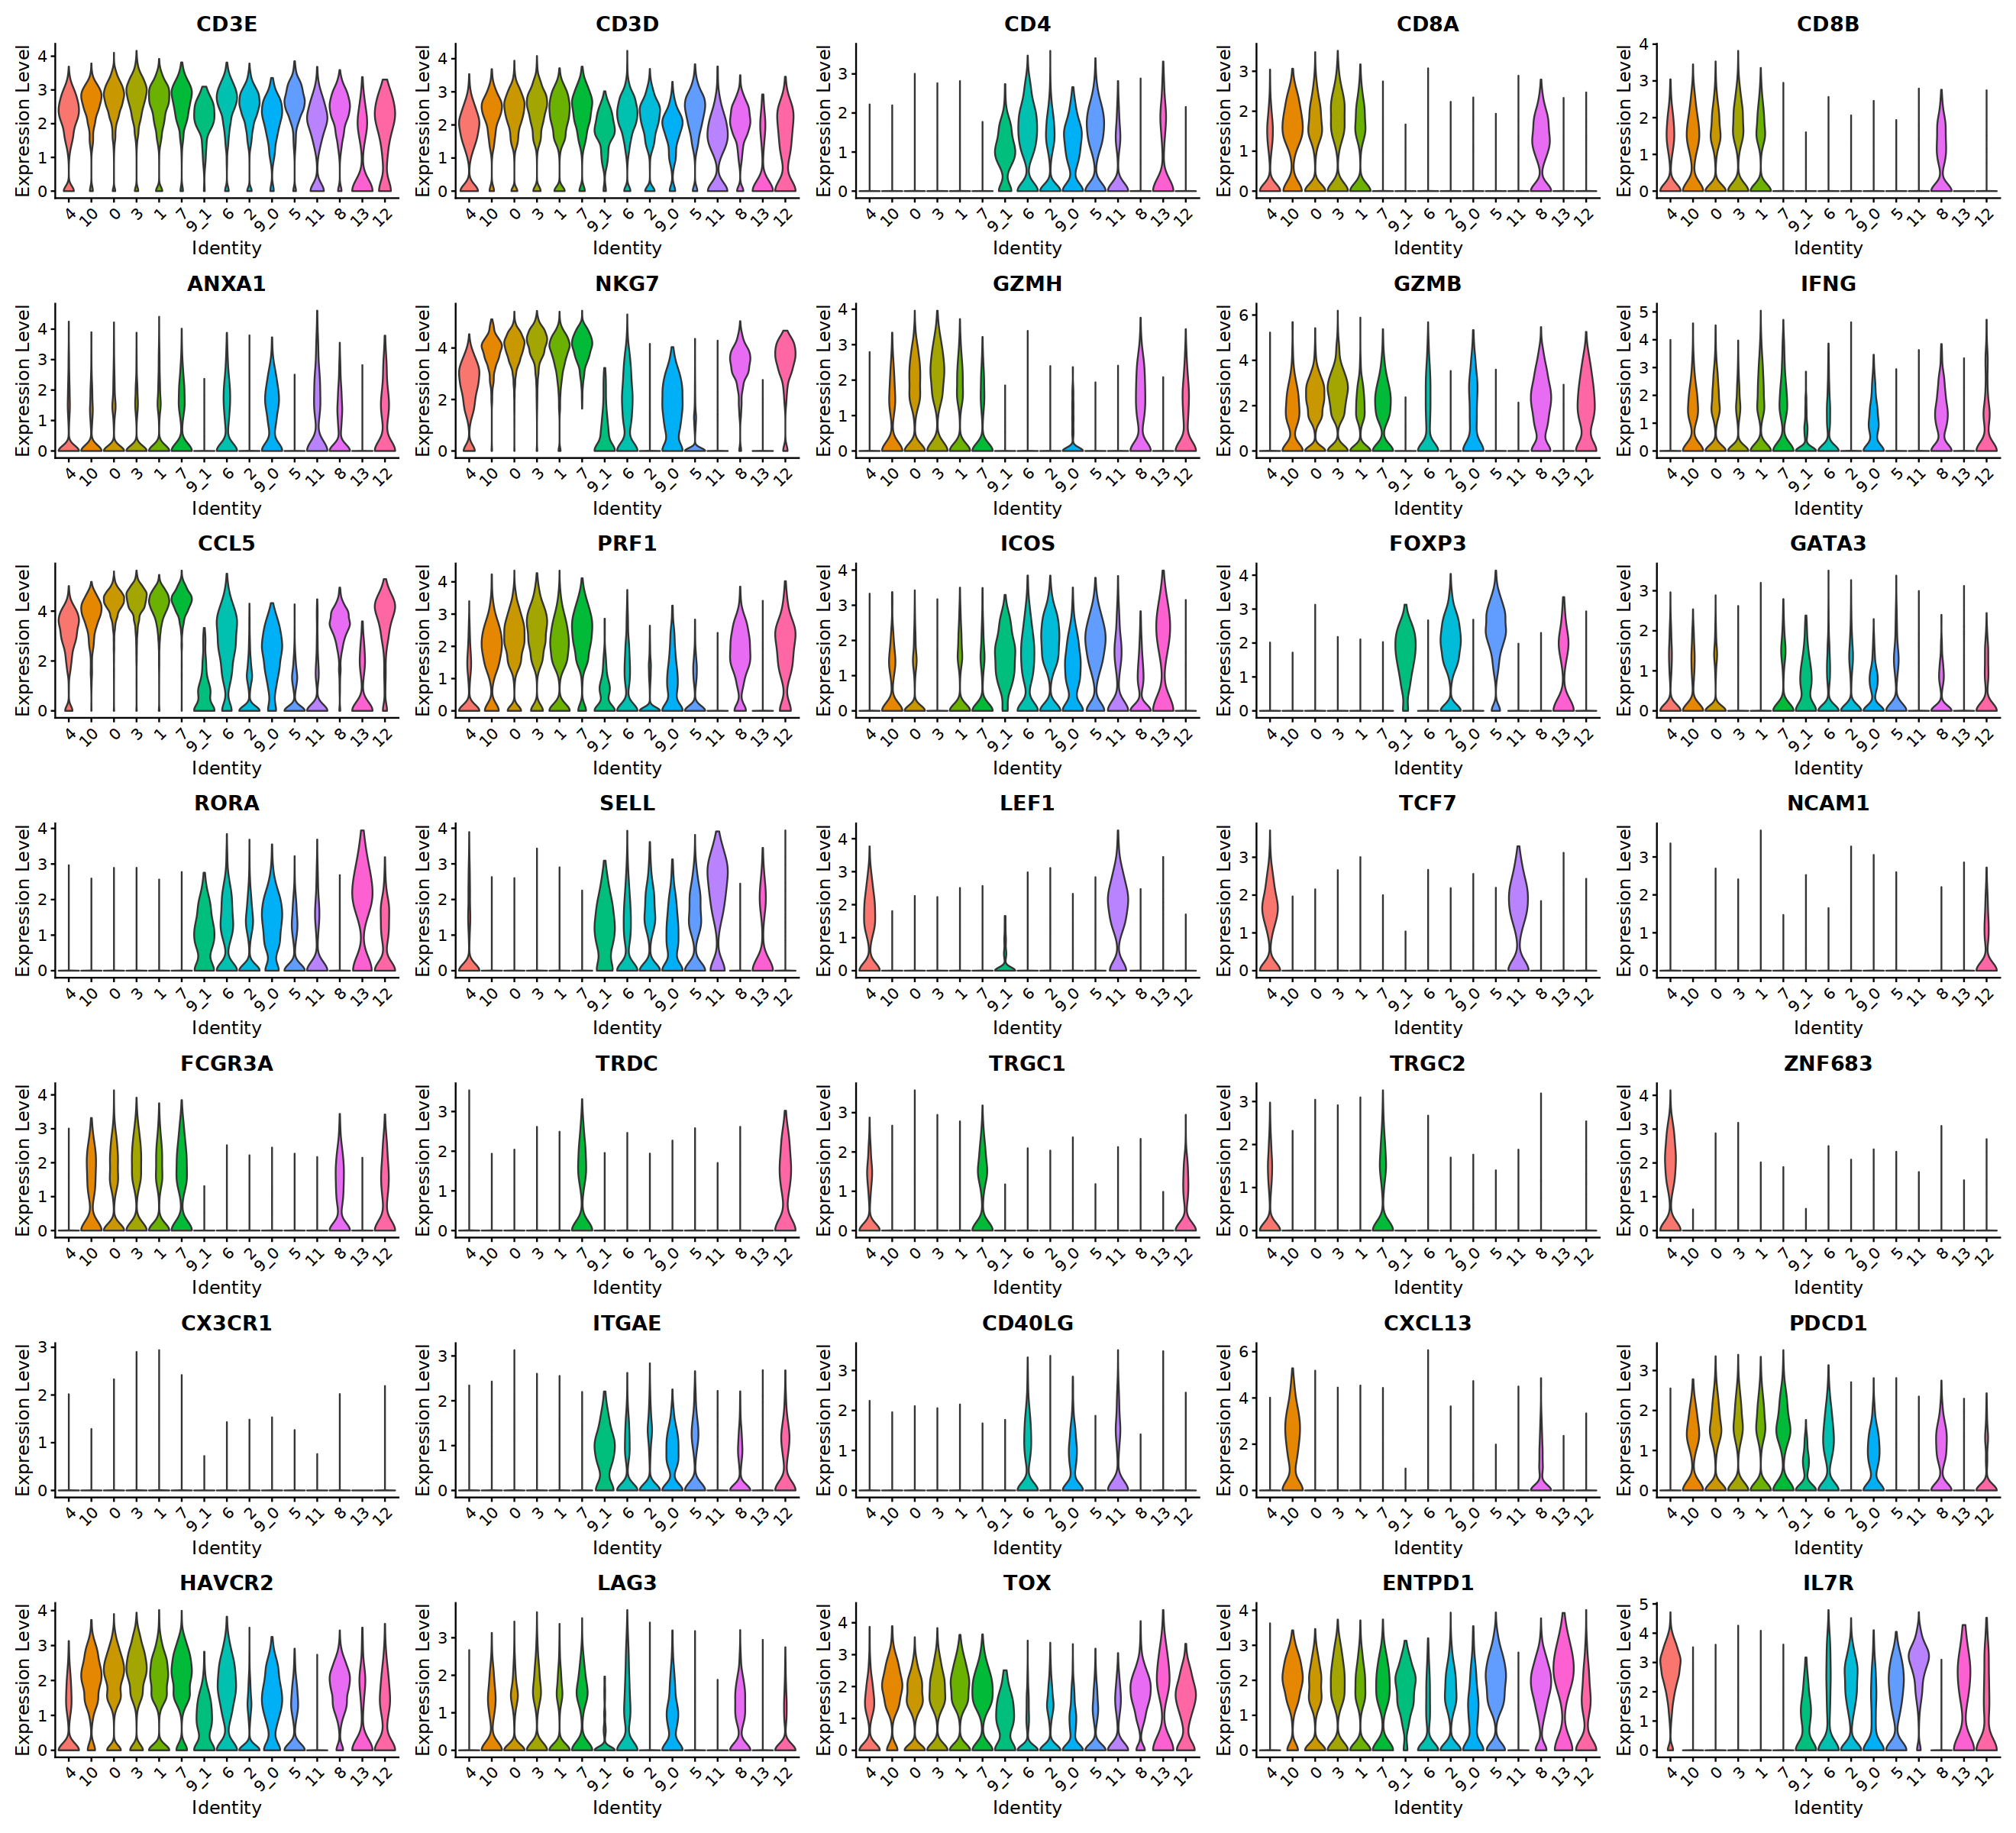

In [43]:
options(repr.plot.width = 22, repr.plot.height = 20, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, 
            feature=tcell_markers, 
            ncol=5, pt.size=0)

Check some one to one differences with a quick wilcox

In [44]:
c0_vs_c1 <- FindMarkers(seurat_obj, ident.1 = "0", ident.2 = "1",logfc.threshold = 0)
c0_vs_c1$gene <- rownames(c0_vs_c1)

In [45]:
c0_vs_c3 <- FindMarkers(seurat_obj, ident.1 = "0", ident.2 = "3",logfc.threshold = 0)
c0_vs_c3$gene <- rownames(c0_vs_c3)

In [46]:
c1_vs_c3 <- FindMarkers(seurat_obj, ident.1 = "1", ident.2 = "3",logfc.threshold = 0)
c1_vs_c3$gene <- rownames(c1_vs_c3)

In [47]:
c0_vs_c1 %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head()

p_val         avg_log2FC pct.1 pct.2 p_val_adj     gene  
FOS    4.394520e-190 1.2905367  0.849 0.506 1.174084e-185 FOS   
ZNF331 1.183109e-131 0.9915544  0.692 0.338 3.160911e-127 ZNF331
FOSB   6.998833e-123 0.8452095  0.731 0.385 1.869878e-118 FOSB  
ZFP36   5.454144e-95 0.8341707  0.793 0.531  1.457184e-90 ZFP36 
GZMB    9.163585e-77 0.7885609  0.789 0.577  2.448235e-72 GZMB  
CD69    3.064352e-95 0.7500957  0.897 0.703  8.187028e-91 CD69

In [48]:
c0_vs_c3 %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head()

p_val         avg_log2FC pct.1 pct.2 p_val_adj     gene  
FOS     0.000000e+00 2.336025   0.849 0.299  0.000000e+00 FOS   
JUN     0.000000e+00 2.211851   0.951 0.500  0.000000e+00 JUN   
DNAJB1  0.000000e+00 1.742655   0.964 0.623  0.000000e+00 DNAJB1
FOSB   2.494356e-252 1.699374   0.731 0.196 6.664172e-248 FOSB  
HSPA1A 1.494146e-307 1.665013   0.988 0.831 3.991910e-303 HSPA1A
HSPA6   3.664951e-44 1.639259   0.330 0.151  9.791651e-40 HSPA6

In [49]:
c1_vs_c3 %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head()

p_val         avg_log2FC pct.1 pct.2 p_val_adj     gene    
HSPA6    2.138682e-156 3.001603   0.542 0.151 5.713918e-152 HSPA6   
DNAJB1    0.000000e+00 2.393389   0.978 0.623  0.000000e+00 DNAJB1  
HSPA1A    0.000000e+00 2.233866   0.998 0.831  0.000000e+00 HSPA1A  
HSPA1B    0.000000e+00 2.146056   0.998 0.817  0.000000e+00 HSPA1B  
JUN      2.085914e-214 1.859649   0.871 0.500 5.572937e-210 JUN     
HSP90AA1  0.000000e+00 1.779278   0.994 0.920  0.000000e+00 HSP90AA1

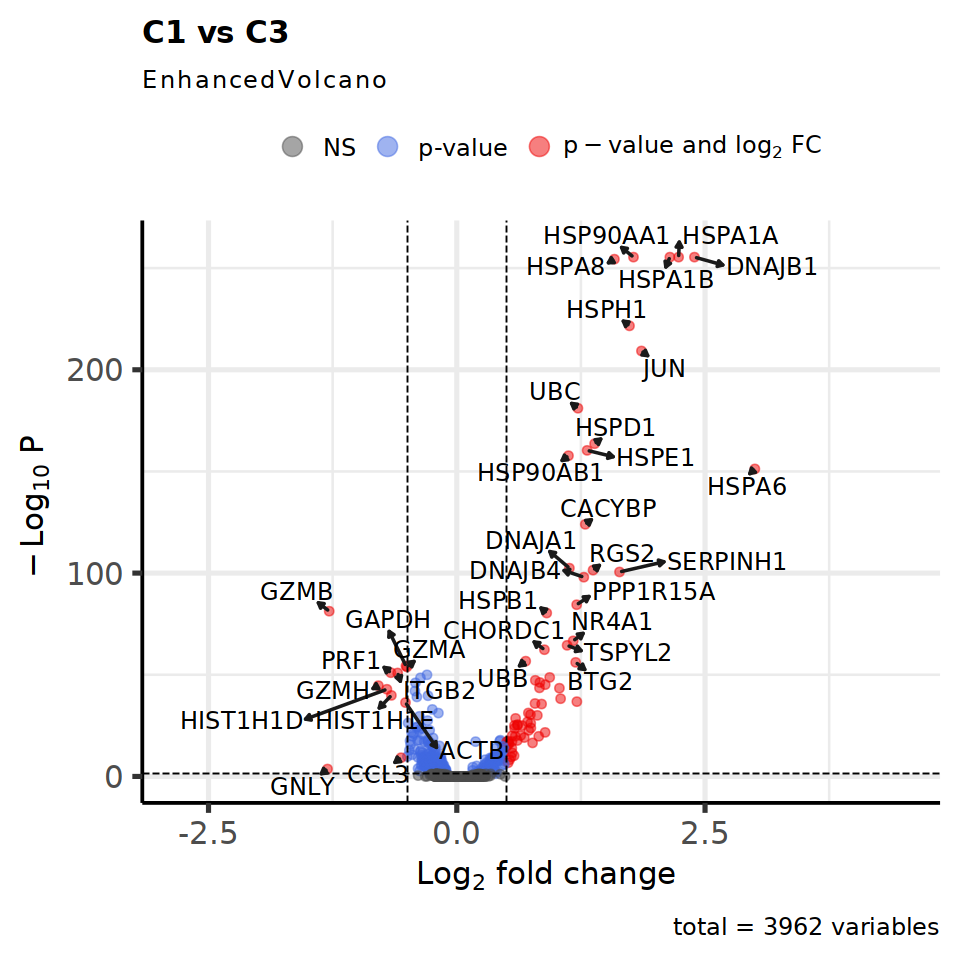

In [50]:
options(repr.plot.width = 8, repr.plot.height = 8, warn=-1,verbose = FALSE)
gg_volcano_DEgenes(c1_vs_c3, "C1 vs C3", "1", "3", 0.5, 0.05)

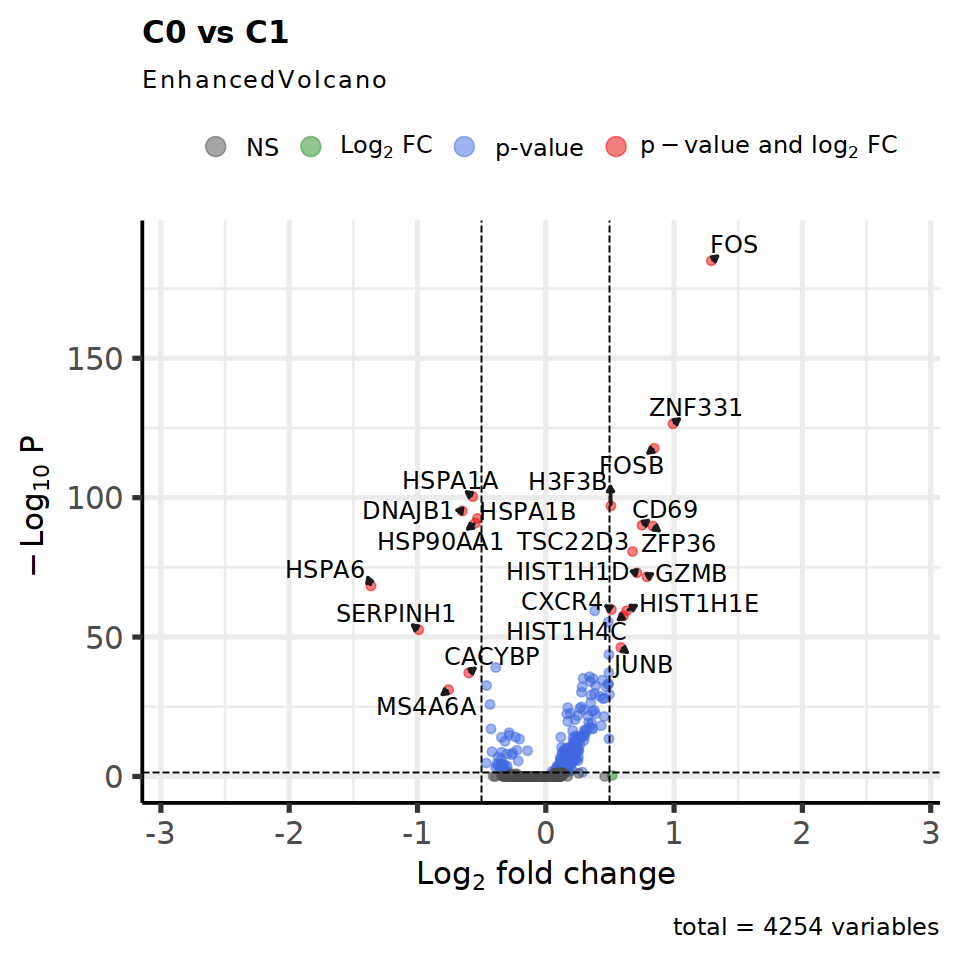

In [51]:
gg_volcano_DEgenes(c0_vs_c1, "C0 vs C1", "0", "1", 0.5, 0.05)

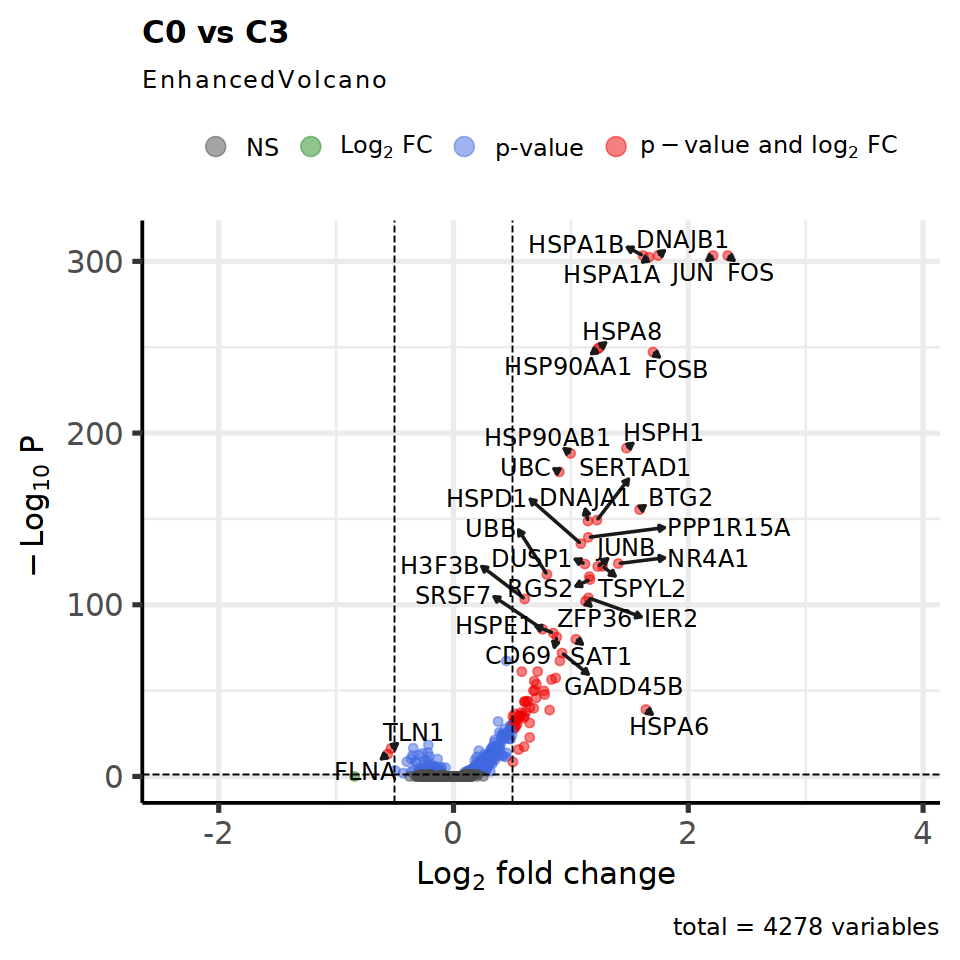

In [52]:
gg_volcano_DEgenes(c0_vs_c3, "C0 vs C3", "0", "3", 0.5, 0.05)

In [53]:
c7_vs_c12 <- FindMarkers(seurat_obj, ident.1 = "7", ident.2 = "12",logfc.threshold = 0)
c7_vs_c12$gene <- rownames(c7_vs_c12)

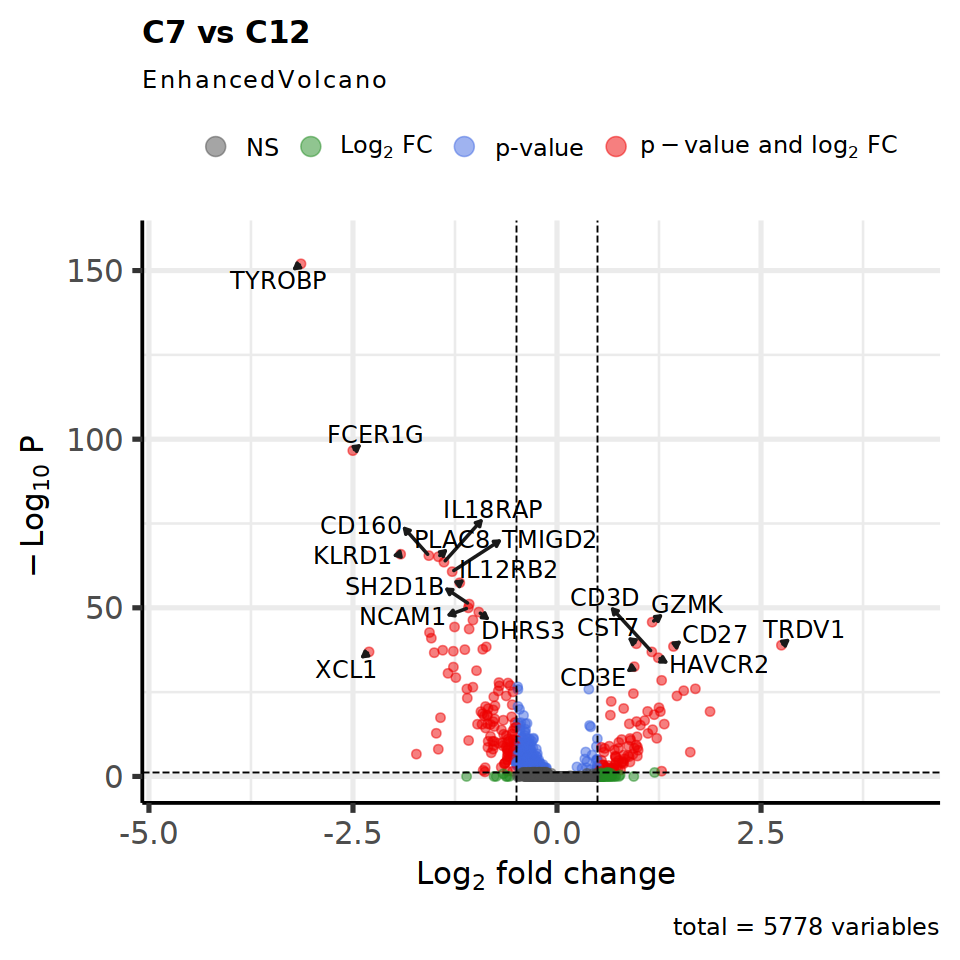

In [54]:
gg_volcano_DEgenes(c7_vs_c12, "C7 vs C12", "7", "12", 0.5, 0.05)

Coloring

In [55]:
cd8_clusters <- c("0","1","3","4","8","10")
cd4_clusters <- c("2","5","6","9_0", "9_1","11","13")
others <- c("7","12")


blue_colors <- c("#0000FF", "#4169E1", "#6495ED", "#87CEEB", 
                 "#00BFFF", "#1E90FF", "#ADD8E6", "#87CEFA")

green_colors <- c("#00FF00", "#32CD32", "#6B8E23", "#228B22", 
                  "#008000", "#9ACD32", "#a1d99b", "#7CFC00")

blue_colors <- blue_colors[1:length(cd8_clusters)]
green_colors <- green_colors[1:length(cd4_clusters)]


names(blue_colors) <- cd8_clusters
names(green_colors) <- cd4_clusters
custom_pal = c(blue_colors, green_colors, c("7"="#6f8a91ff", "12"="#53676cff"))

In [56]:
custom_pal

0           1           3           4           8          10 
  "#0000FF"   "#4169E1"   "#6495ED"   "#87CEEB"   "#00BFFF"   "#1E90FF" 
          2           5           6         9_0         9_1          11 
  "#00FF00"   "#32CD32"   "#6B8E23"   "#228B22"   "#008000"   "#9ACD32" 
         13           7          12 
  "#a1d99b" "#6f8a91ff" "#53676cff"

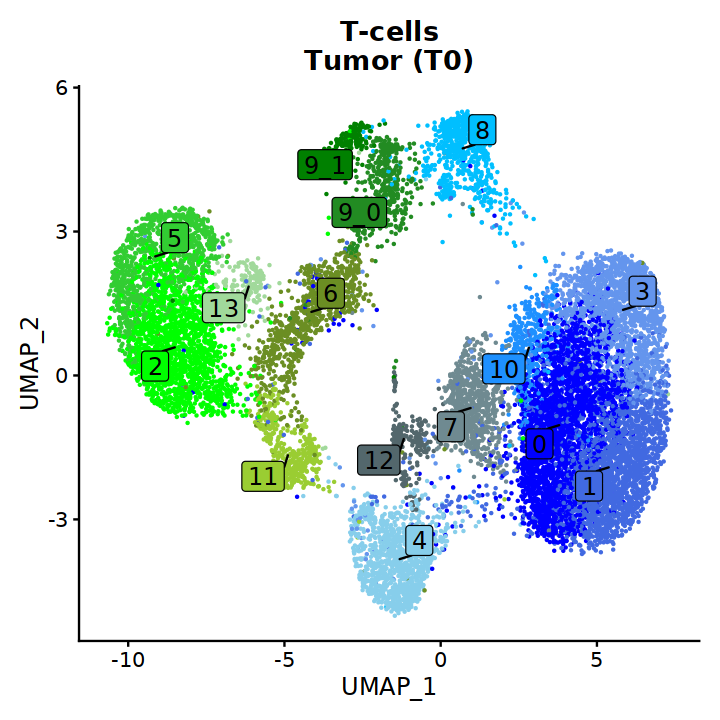

In [57]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
dpc <- DimPlot(seurat_obj, reduction = "umap", cols=custom_pal,pt.size = 0.2,
        label = T,
        label.box = TRUE,
        label.size = 5,
        repel = TRUE,) + 
    NoLegend() +
    labs(title=glue("T-cells\nTumor (T0)")) + theme(plot.title = element_text(hjust = 0.5))
dpc

In [58]:
markers = c("CD8A", "CD8B", 
            "GZMH","PRF1", "GZMB","HAVCR2","LAG3","IFNG","PDCD1", "CXCL13", "CRTAM","ZNF683",
            "CD4", "SELL","LEF1", "IL7R","CD40LG", "RORA","TOP2A","MKI67", "FOXP3", 
            "TRGV9", "TRDV1", "ZBTB16", "KLRF1")

In [59]:
clust_order= c("0","3","1","10","4","8","11","6","9_0","9_1","2","5","13","7","12")

In [60]:
seurat_obj$Tcell_clusters <- factor(seurat_obj$Tcell_clusters, levels = clust_order)

Main markers

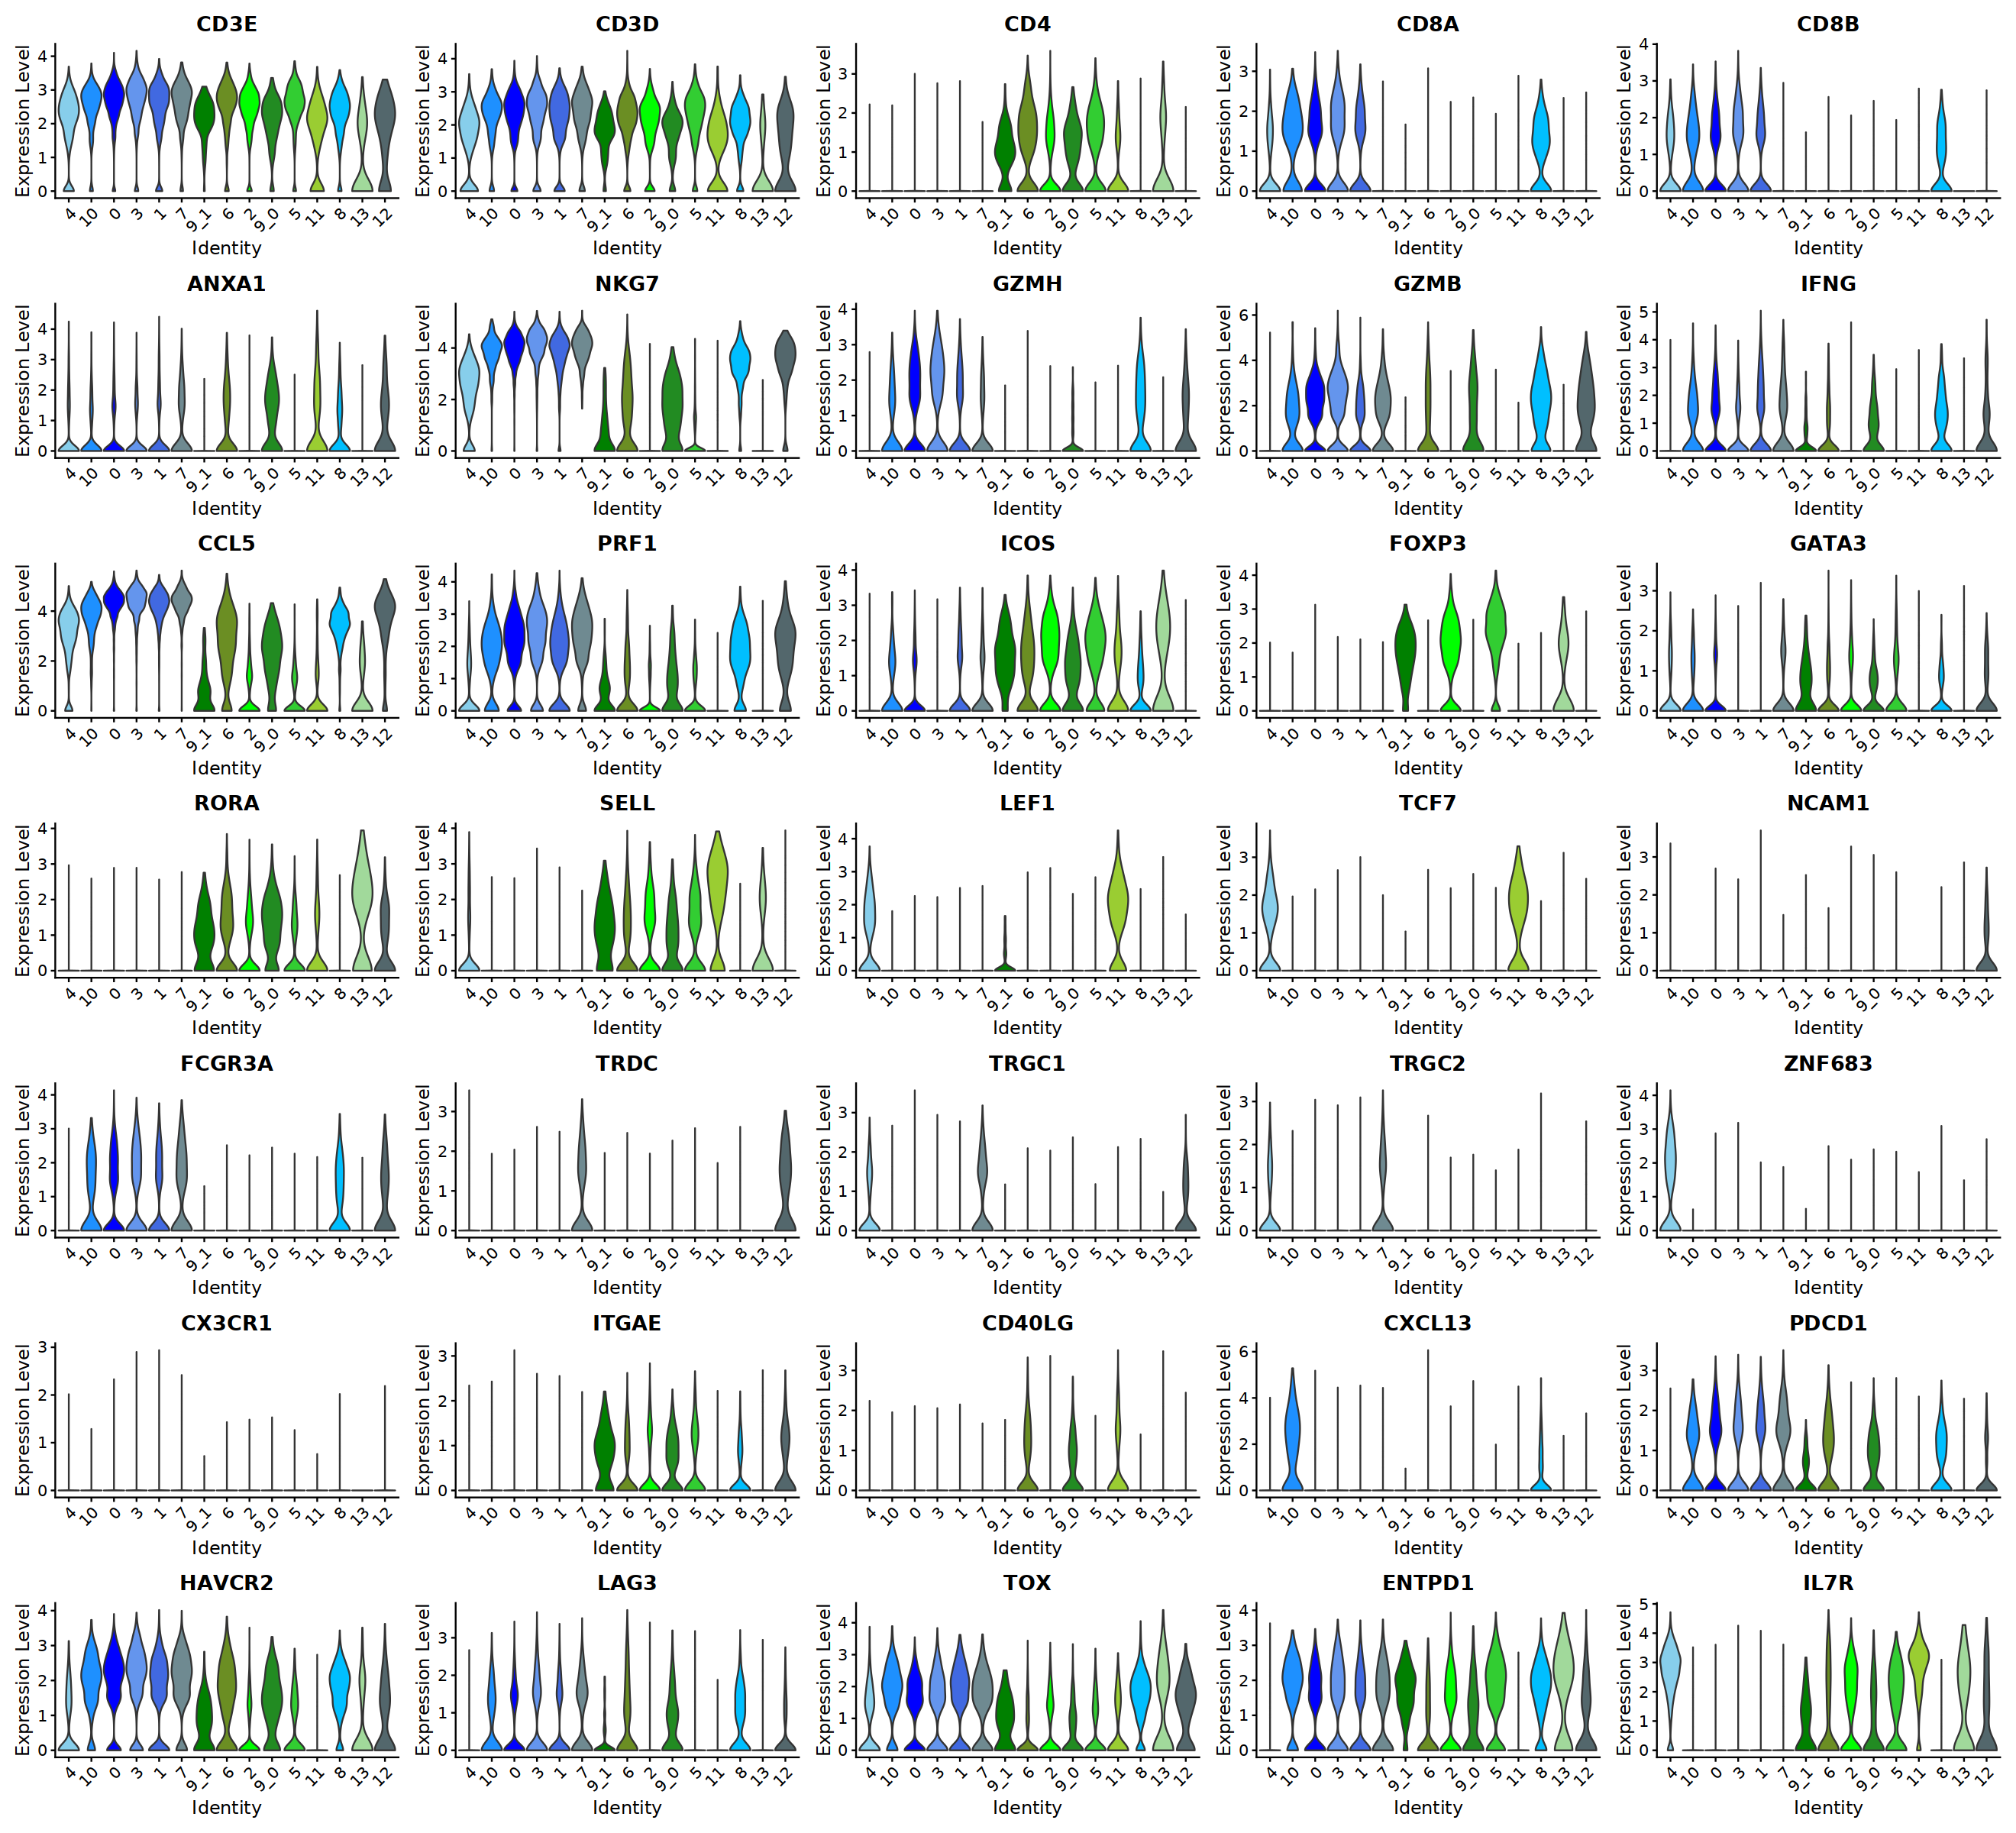

In [61]:
options(repr.plot.width = 22, repr.plot.height = 20, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, 
            feature=tcell_markers, 
            ncol=5, pt.size=0,
            cols=custom_pal)

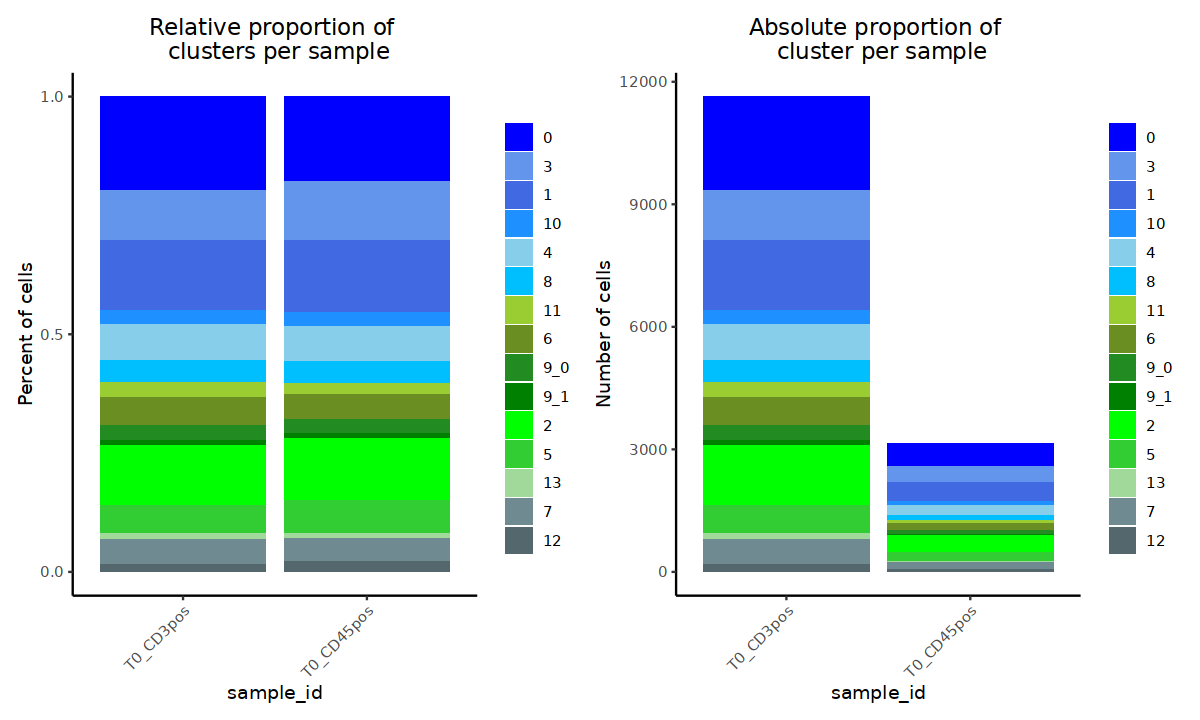

In [62]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
abs <- dittoBarPlot(seurat_obj, "Tcell_clusters", group.by = "sample_id",
                    color.panel = custom_pal,retain.factor.levels=T) + 
       labs(title = "Relative proportion of \n clusters per sample") +
        theme(plot.title = element_text(hjust = 0.5))
rel <- dittoBarPlot(seurat_obj, "Tcell_clusters", group.by = "sample_id", 
             scale = "count", color.panel = custom_pal,retain.factor.levels=T) + 
            labs(title ="Absolute proportion of \n cluster per sample") + theme(plot.title = element_text(hjust = 0.5))
abs + rel

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


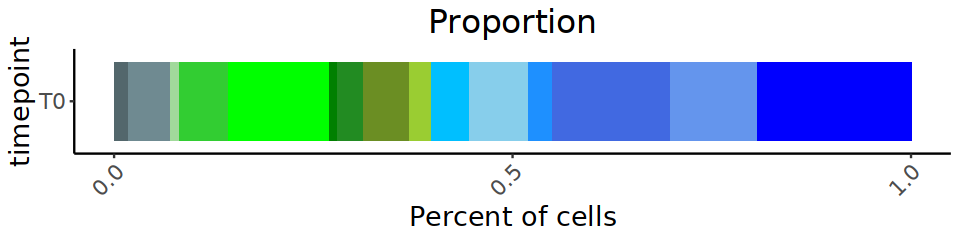

In [63]:
options(repr.plot.width = 8, repr.plot.height = 2, warn=-1,verbose = FALSE)
prop_plot <- dittoBarPlot(seurat_obj, "Tcell_clusters", group.by="timepoint",
                    color.panel = custom_pal,retain.factor.levels=T) + 
       labs(title = "Proportion") +
        theme(plot.title = element_text(hjust = 0.5),
             text = element_text(size=16))+ NoLegend() + coord_flip()
prop_plot

In [64]:
ggsave(prop_plot,width = 8, height = 2, dpi = 300, 
       file=here(glue("{annot}/{plt_dir}/4.2-Tcells_bar_prop.svg")))

In [65]:
vln1 <- VlnPlot(seurat_obj, 
            feature=c("FOXP3"), 
            pt.size=0,
            cols=custom_pal) + NoLegend()

In [66]:
vln2 <- VlnPlot(seurat_obj, 
            feature=c("CD40LG"), 
            pt.size=0,
            cols=custom_pal) + NoLegend()

In [67]:
fp1 <- FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("FOXP3"), 
            order = TRUE) +
    scale_color_viridis_c(option = "magma")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [68]:
fp2 <- FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("CD40LG"), 
            order = TRUE) +
    scale_color_viridis_c(option = "magma")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


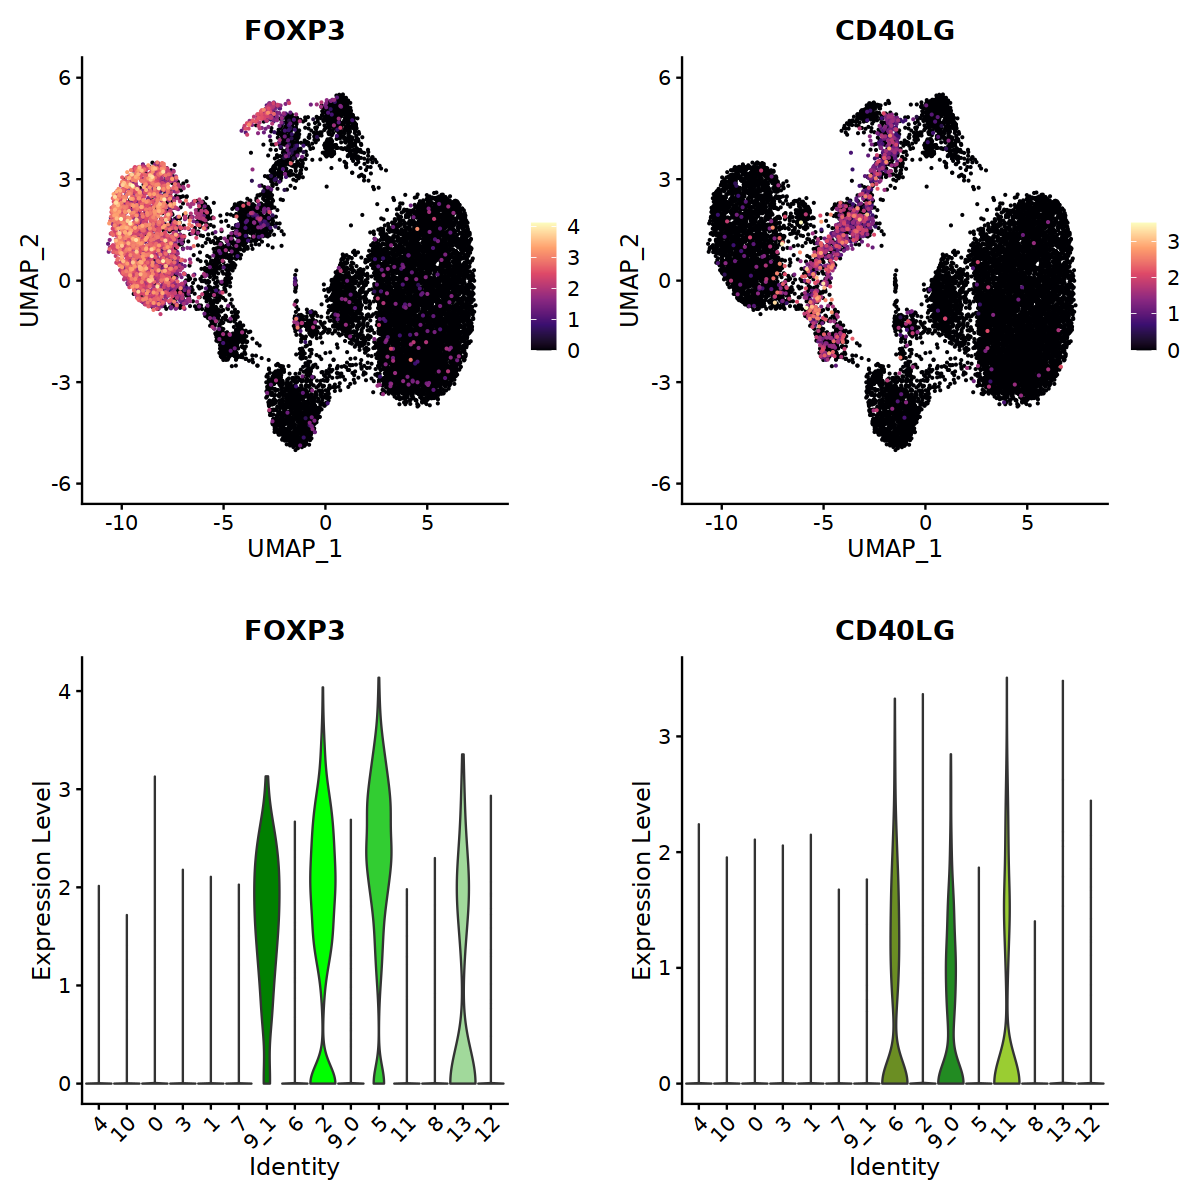

In [69]:
options(repr.plot.width = 10, repr.plot.height =10, warn=-1,verbose = FALSE)
cd4_pl <- cowplot::plot_grid(plotlist = list(fp1,fp2,vln1, vln2),
                   align = "hv",
                   axis = "trbl",
                   ncol=2,
                   nrow=2)
cd4_pl

In [70]:
cowplot::save_plot(plot = cd4_pl, filename=here(glue("{annot}/{plt_dir}/4.2-CD4_compart.png")),
          base_width=10, base_height=10)   

#### Save

In [71]:
seurat_obj@meta.data <- seurat_obj@meta.data[,c('orig.ident','nCount_RNA','nFeature_RNA','sample_org',
                        'timepoint','replicate','sample_id','pct_mt',
                        'percent.ribo','doublet_score','doublet_pred',
                        'S.Score','G2M.Score','Phase','old.ident',
                        'l1_annot','Tcell_clusters')]

In [72]:
write_csv(rna.markers, here(glue("{annot}/{robj_dir}/4.2-subset_tcell_only_1.csv")))

In [73]:
saveRDS(seurat_obj, here(glue("{annot}/{robj_dir}/4.2-subset_tcell_noannot.rds")))

In [74]:
proportions <- prop.table(table(seurat_obj$Tcell_clusters))

In [75]:
proportions


         0          3          1         10          4          8         11 
0.19365745 0.10933802 0.14875921 0.02914328 0.07431199 0.04733248 0.02853472 
         6        9_0        9_1          2          5         13          7 
0.05754277 0.03184800 0.01081885 0.12597201 0.06214078 0.01163027 0.05233620 
        12 
0.01663398 

# Save

In [76]:
saveRDS(seurat_obj, here(glue("{annot}/{robj_dir}/4.2-subset_tcell.rds")))
write.csv(seurat_obj@meta.data, here(glue("{annot}/{robj_dir}/4.2-subset_tcell_annot.csv")), row.names=TRUE)

In [77]:
ggsave(plot = dpc, width = 8, height = 8, dpi = 300, 
       file = here::here(glue::glue("{annot}/{plt_dir}/4.2-umap_subset_tcell.svg")))

In [78]:
ggsave(plot = dpc, width = 6, height = 6, dpi = 300, 
       file = here::here(glue::glue("{annot}/{plt_dir}/4.2-umap_subset_tcell.png")))

# Session Info

In [79]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_2.28.0    